### Effect of Gaussian noise on the primary and secondary masses, on the spin magnitudes, and on the effective inspiral and effective precessing spin on GW231123-like signals

NRSUR maximum-likelihood injections in Gaussian noise and zero-noise. Same code for Figure 3 (NRSUR), 4 (XPHM) and 5 (XO4a), and Figure 8 (inference using single-detector individually)

In [1]:
import bilby
import matplotlib.pyplot as plt
import glob
import numpy as np
import h5py
import pandas as pd
from pesummary.utils.samples_dict import MultiAnalysisSamplesDict
from scipy import stats
from scipy.stats import gaussian_kde
from pesummary.utils.bounded_2d_kde import Bounded_2d_kde
from pesummary.utils.bounded_1d_kde import bounded_1d_kde
import seaborn as sns
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import matplotlib.ticker as ticker
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
matplotlib.rcParams.update({'font.size': 17})
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['legend.fontsize'] = 20
import matplotlib.collections as mcoll
import matplotlib.lines as mlines
from scipy.stats import gaussian_kde as kde
import scipy as sp
import config
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["BILBY_INCLUDE_GLOBAL_META_DATA"] = "1"

/home/pe.o4/GWTC4-fogg/environment/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/pe.o4/GWTC4-fogg/environment/lib/python3.10/site-packages/pesummary/gw/plots/plot.py:21: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import MSUN_SI, PC_SI, CreateDict


In [2]:
#select waveform model
wf ='NRSUR'

In [3]:
#Load samples from simulations in Gaussian noise

result_files = {}

#for XPHM ------------------------------------------------------------------
result_files['XPHM'] = glob.glob(f"/home/sophie.bini/project/PE/231123_NR_simulatedNoise/maxL/XPHM_LH/outdir_XPHM_H1L1/final_result/maxL_injection_XPHM_H1L1_data*_1384782888-634277_analysis_H1L1_result.hdf5")
#for NRSUR -----------------------------------------------------------------
result_files['NRSUR'] = glob.glob(f"/home/sophie.bini/project/PE/231123_NR_simulatedNoise/maxL/NRSUR_LH/outdir_H1L1_nrsur/final_result/maxL_injection_H1L1_nrsur_data*_1384782888-634277_analysis_H1L1_result.hdf5")
#for XO4a
result_files['XO4a'] = glob.glob(f"/home/sophie.bini/project/PE/231123_NR_simulatedNoise/maxL/XO4a_LH/outdir_XO4a_H1L1/final_result/maxL_injection_H1L1_XO4a_data*_1384782888-634277_analysis_H1L1_result.hdf5")

results = dict()
for model in result_files:
    results[model] = {}
    for file in result_files[model]:
        
        #print(file)
        run = file.split("_data")[1].split("_1384782888")[0]
        results[model][run] = bilby.result.read_in_result(file)

print(len(results[wf]))

20


In [4]:
#Load simulation in zero-noise
result_0_noise_files = {}
#NRSUR
result_0_noise_files['NRSUR'] = config.maxLNRSUR_BF_NRSUR
#XPHM 
result_0_noise_files['XPHM'] = config.maxLNRSUR_BF_XPHM
#XO4a
result_0_noise_files['XO4a'] = config.maxLNRSUR_BF_XO4a
results_0noise = dict()

for model in result_0_noise_files:
    print(model)
    results_0noise[model]= bilby.result.read_in_result(result_0_noise_files[model])

NRSUR
XPHM
XO4a


In [5]:
#Load GW231123 results (LVK release)
results_GW231123_files={}
results_GW231123_files['XPHM'] = config.gw231123_BF_XPHM
results_GW231123_files['XO4a'] = config.gw231123_BF_XO4a
results_GW231123_files['NRSUR']  = config.gw231123_BF_NRSUR

results_GW231123 = dict()

for model in results_GW231123_files:
    results_GW231123[model]= bilby.result.read_in_result(results_GW231123_files[model])

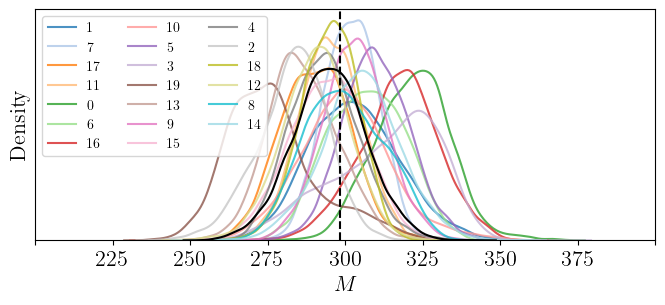

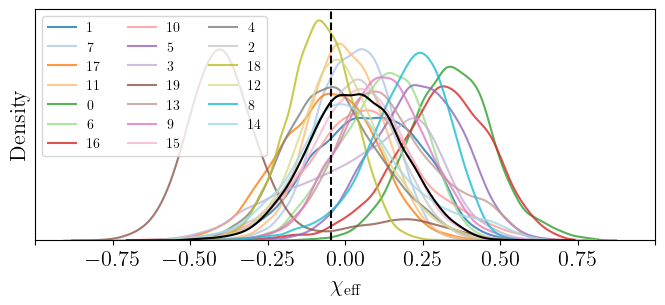

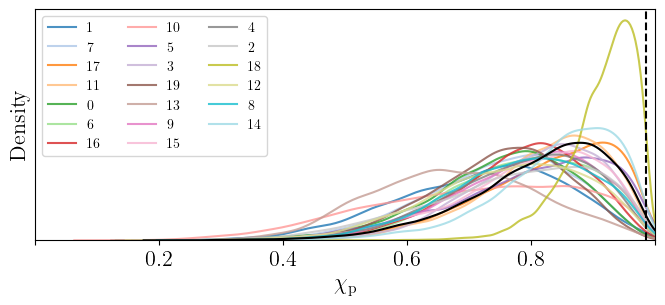

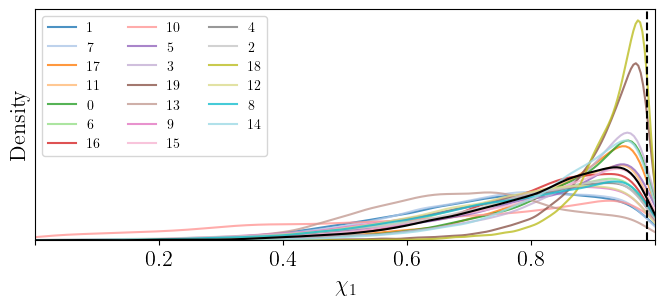

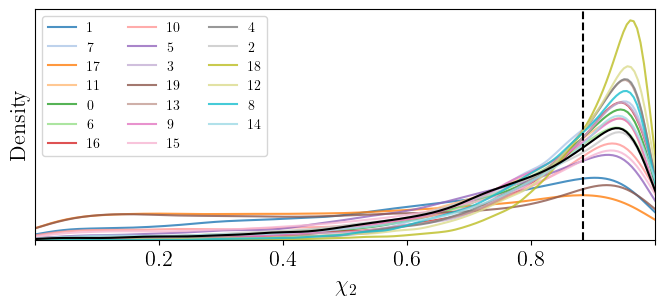

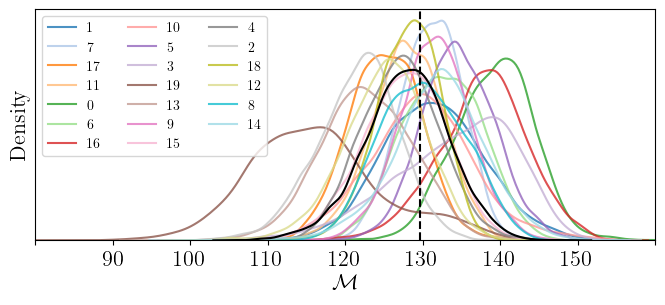

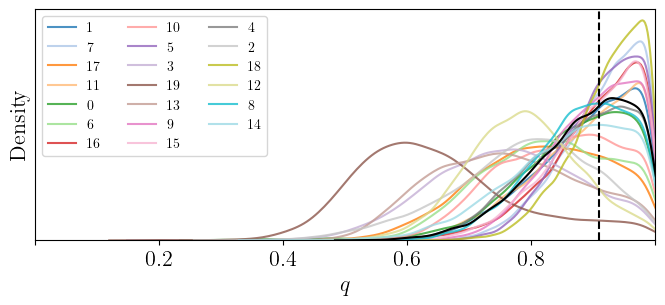

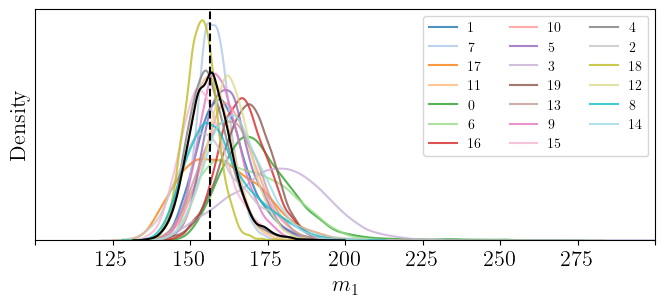

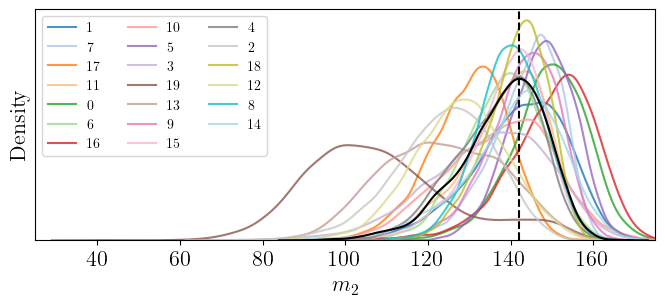

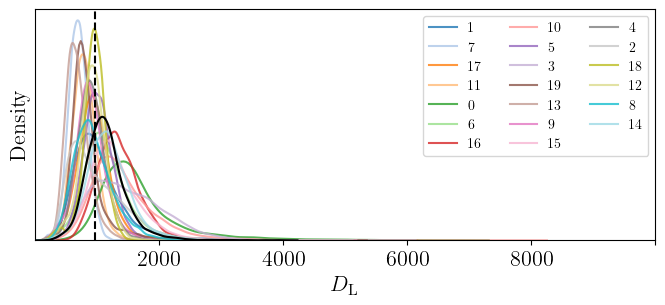

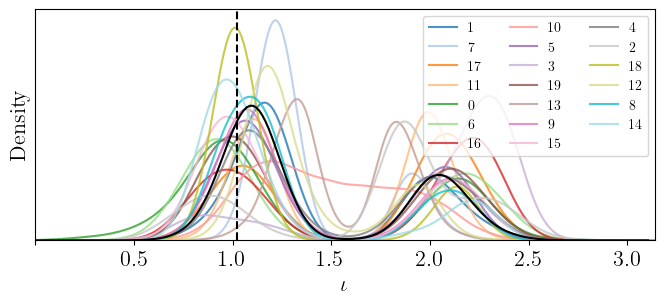

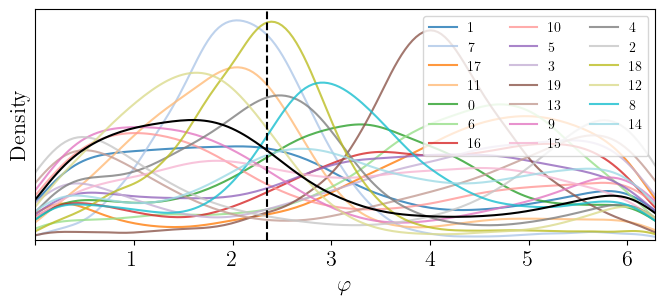

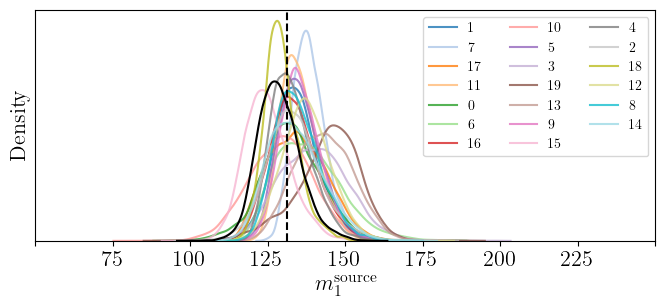

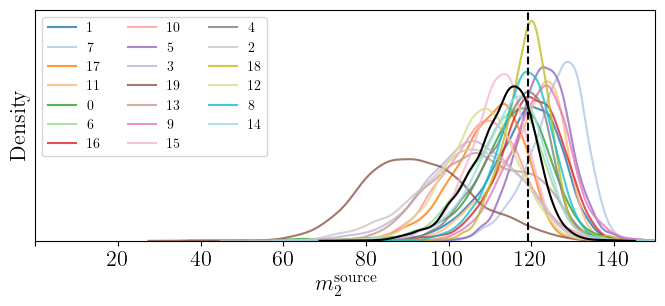

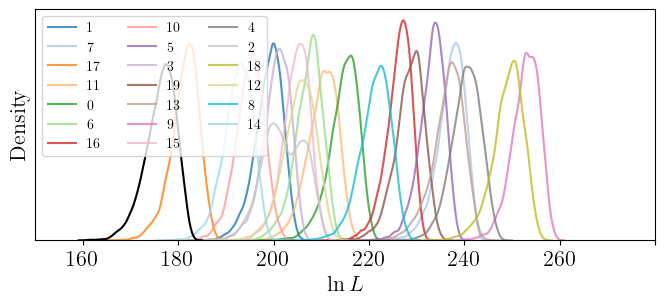

In [6]:
#check: plot samples from simulations in Gaussian noise with different colors.

params = ['total_mass', 'chi_eff', 'chi_p', 'a_1', 'a_2', 'chirp_mass', 'mass_ratio', 'mass_1', 'mass_2', 'luminosity_distance', 'iota', 'phase', 'mass_1_source', 'mass_2_source','log_likelihood']
ax_dets = {'L1': 0}
lims = {'total_mass':(200, 400), 'mass_1':(100,300), 'mass_2':(25,175), 'chi_eff':(-1,1), 'chi_p':(0,1), 'mass_ratio':(0,1), 'luminosity_distance':(1,10000), 'iota':(0,3.14152), 'a_1':(0,1), 'a_2':(0,1), 'phase':(0,2*np.pi), 'chirp_mass':(80, 160), 'mass_1_source':(50, 250), 'mass_2_source':(0,150), 'log_likelihood':(150,280)}
event_js = {'total_mass': 0.373, 'chi_eff': 0.477, 'chi_p': 0.236, 'mass_1': 0.376, 'mass_2': 0.098, 'mass_ratio': 0.105, 'chirp_mass': 0.236, 'luminosity_distance': 0.609, 'iota': 0.352, 'phase': 0.467, 'a_1': 0.020, 'a_2': 0.003, 'mass_1_source': 0.367, 'mass_2_source': 0.250}
param_to_str = {'total_mass':r'$M$', 'mass_1':r'$m_1$', 'mass_2':r'$m_2$', 'chi_eff':r'$\chi_{\rm{eff}}$', 'chi_p':r'$\chi_{\rm{p}}$', 'mass_ratio':r'$q$', 'luminosity_distance':r'$D_{\rm{L}}$', 'iota':r'$\iota$', 'a_1':r'$\chi_1$', 'a_2':r'$\chi_2$', 'phase':r'$\varphi$', 'chirp_mass':r'$\mathcal{M}$', 'mass_1_source':r'$m_1^{\rm{source}}$', 'mass_2_source':r'$m_2^{\rm{source}}$', 'log_likelihood':r'$\ln L$'}
det_to_str = {'H1':'Hanford', 'L1':'Livingston'}

fractions = {}
cmap = plt.cm.tab20  
colors = cmap.colors

for param in params:
    fig, axes = plt.subplots(1, 1, figsize=(8, 3))
    fig.subplots_adjust(wspace=0)
    
    # Posteriors
    colors = [cmap(j % cmap.N) for j in range(20)]
    for j, run in enumerate(results[wf]):
        sns.kdeplot(results[wf][run].posterior, x=param, color=colors[j % len(colors)], alpha=0.8,label=f'{run}')
        
    #zero-noise
    sns.kdeplot(results_0noise[wf].posterior, x=param, color='black', alpha=1)
    #add injected value 
    if param!='log_likelihood':
        axes.axvline(results[wf][run].injection_parameters[param], color='k', ls='--')
        
    axes.legend(ncols=3, fontsize=10)         
    axes.set_xlim(lims[param][0], lims[param][1])
    axes.set_xlabel(f"{param_to_str[param]}", fontsize=16)
    axes.set_ylabel('Density', fontsize=16)
    axes.set_yticks([])
    axes.get_xticklabels()[0].set_visible(False)
    axes.get_xticklabels()[-1].set_visible(False)

In [7]:
#Define bounded KDE
#from https://git.ligo.org/publications/o4/cbc/gwtc-4-results/-/blob/main/scripts/plotting/catplot/functions.py

class Bounded_1d_kde(kde):
    r"""Represents a one-dimensional Gaussian kernel density estimator
    for a probability distribution function that exists on a bounded
    domain."""

    def __init__(self, pts, xlow=None, xhigh=None, *args, **kwargs):
        """Initialize with the given bounds.  Either ``low`` or
        ``high`` may be ``None`` if the bounds are one-sided.  Extra
        parameters are passed to :class:`gaussian_kde`.

        :param xlow: The lower x domain boundary.

        :param xhigh: The upper x domain boundary.
        """
        pts = np.atleast_1d(pts)

        assert pts.ndim == 1, 'Bounded_1d_kde can only be one-dimensional'

        super(Bounded_1d_kde, self).__init__(pts.T, *args, **kwargs)

        self._xlow = xlow
        self._xhigh = xhigh

    @property
    def xlow(self):
        """The lower bound of the x domain."""
        return self._xlow

    @property
    def xhigh(self):
        """The upper bound of the x domain."""
        return self._xhigh

    def evaluate(self, pts):
        """Return an estimate of the density evaluated at the given
        points."""
        pts = np.atleast_1d(pts)
        assert pts.ndim == 1, 'points must be one-dimensional'

        x = pts.T
        pdf = super(Bounded_1d_kde, self).evaluate(pts.T)
        if self.xlow is not None:
            pdf += super(Bounded_1d_kde, self).evaluate(2*self.xlow - x)

        if self.xhigh is not None:
            pdf += super(Bounded_1d_kde, self).evaluate(2*self.xhigh - x)

        return pdf

    def __call__(self, pts):
        pts = np.atleast_1d(pts)
        out_of_bounds = np.zeros(pts.shape[0], dtype='bool')

        if self.xlow is not None:
            out_of_bounds[pts < self.xlow] = True
        if self.xhigh is not None:
            out_of_bounds[pts > self.xhigh] = True

        results = self.evaluate(pts)
        results[out_of_bounds] = 0.
        return results


#from https://git.ligo.org/publications/o4/cbc/gwtc-4-results/-/blob/main/scripts/plotting/cbcBayesPostUtilities.py

def makeKde(data, Nbins, xMin, xMax, bounded=False, bw_method=None):
    """Compute KDE of `data` normalised across interval [`xMin`, `xMax`]
    using Nbins bins.
    If `bounded` is true, use a bounded KDE method with bounds `xMin`, `xMax`.
    """
    xPoints = np.linspace(xMin, xMax, Nbins)
    if bounded:
        kernel = Bounded_1d_kde(data,#np.atleast_2d(data).T, 
                                xlow=xMin, xhigh=xMax, bw_method=bw_method)
        #return kernel(np.atleast_2d(xPoints).T)
        return kernel(xPoints)
    else:
        kernel = sp.stats.gaussian_kde(data)
        return kernel.evaluate(xPoints) / kernel.integrate_box_1d(xMin, xMax)

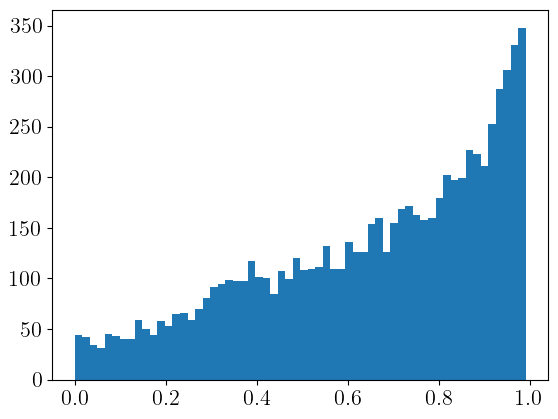

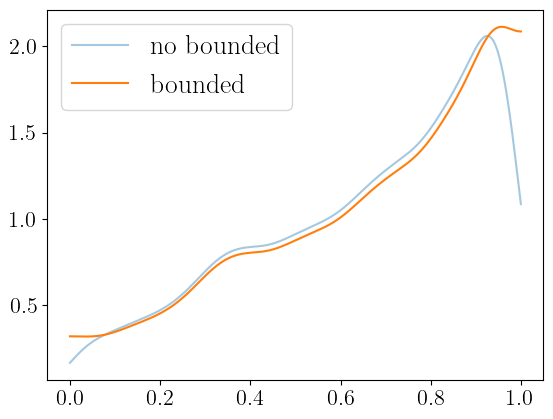

In [8]:
#check bounded KDE on spin magnitude
data= results['NRSUR']['10'].posterior['a_1'].values
plt.hist(data,bins=60)
plt.show()
xMin=0
xMax=1
Nbins=1000
x = np.linspace(xMin, xMax, Nbins)
plt.plot(x, makeKde(data,Nbins, xMin, xMax, bounded=False),alpha=0.4,label='no bounded')
plt.plot(x, makeKde(data,Nbins, xMin, xMax, bounded=True), label='bounded')
plt.legend()
plt.show()

In [9]:
#load priors for chi eff and chi p
priors = results['NRSUR']['11'].priors.sample(size=5000)
priors = bilby.gw.conversion.generate_all_bbh_parameters(priors)
spin_priors=[]
for i, param in enumerate(['chi_eff','chi_p']):
    spin_priors.append(priors[param])
spin_priors

22:31 bilby WARNING : Prior sampling efficiency is very low, please verify its validity.


[array([-0.01064425,  0.17293826, -0.13226386, ..., -0.2923138 ,
         0.20066294,  0.01493495]),
 array([0.01606391, 0.59470151, 0.15132679, ..., 0.70677237, 0.57101148,
        0.04193814])]

### Create final plot

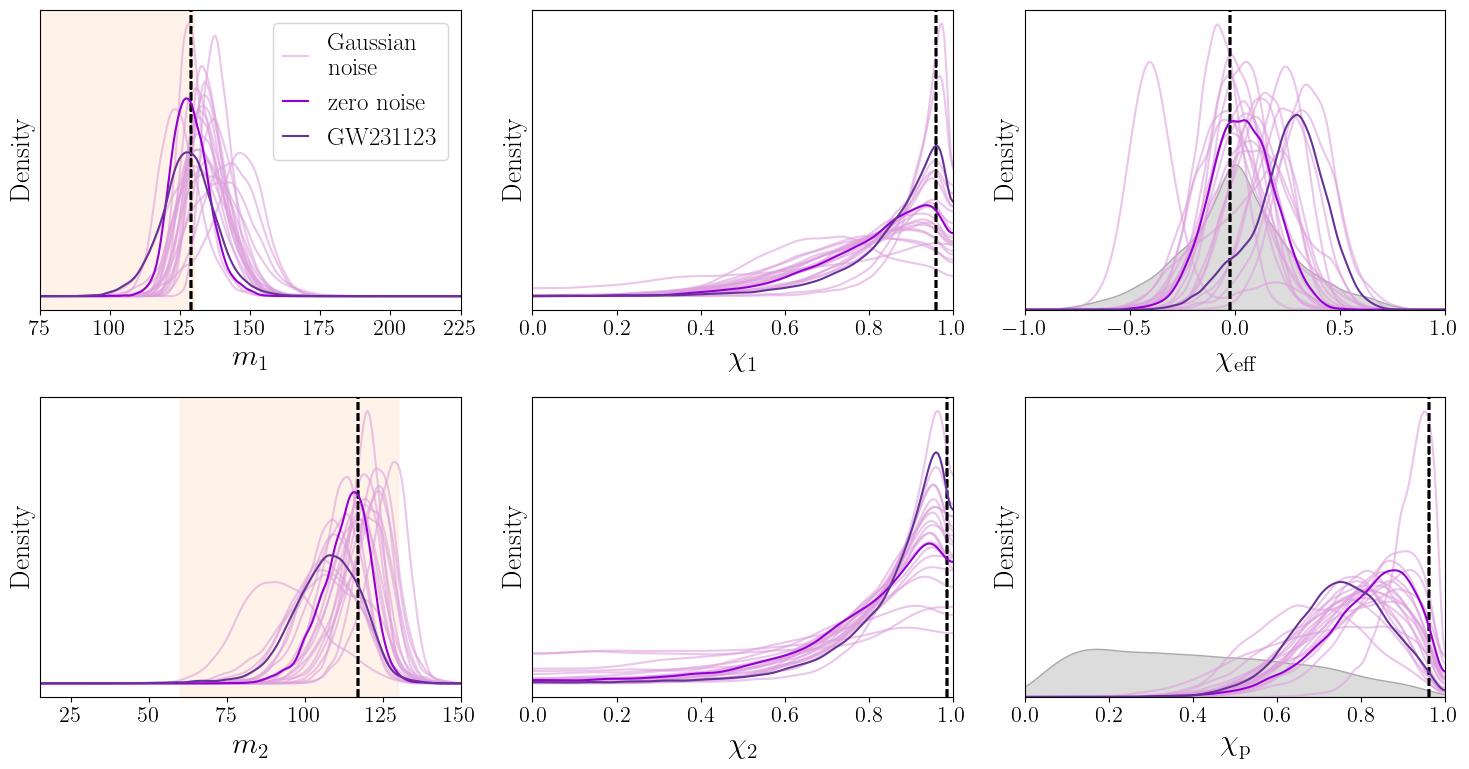

In [10]:
params= ['mass_1_source', 'a_1', 'chi_eff', 'mass_2_source','a_2', 'chi_p']
colors = {"NRSUR": 'plum',"XPHM": 'lightskyblue',"XO4a": 'palegreen'}
colors_0noise = {"NRSUR": 'darkviolet',"XPHM": 'deepskyblue',"XO4a": 'limegreen'}
colors_gw231123 = {"NRSUR": 'rebeccapurple',"XPHM": 'royalblue',"XO4a": 'darkgreen'}
lims = {'chi_eff':(-1,1), 'chi_p':(0,1), 'a_1':(0,1), 'a_2':(0,1),
        'mass_1_source':(75, 225), 'mass_2_source':(15,150)}
param_to_str = {'mass_1_source':r'$m_1$', 'mass_2_source':r'$m_2$','a_1':r'$\chi_1$', 'a_2':r'$\chi_2$', 'chi_eff':r'$\chi_{\rm{eff}}$', 'chi_p':r'$\chi_{\rm{p}}$'}

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()  

for i, param in enumerate(params):
    ax = axes[i]

    #draw mass gap
    if i == 0 or i ==3:
        ax.axvspan(60, 130, color='peachpuff', alpha=0.3)

    #prior for chi eff and chi p
    if i == 2: #chi_eff 
        sns.kdeplot(spin_priors[0], color='darkgrey', alpha=0.4, ax=ax, fill=True)
    if i == 5: #chi_p
        sns.kdeplot(spin_priors[1], color='darkgrey', alpha=0.4, ax=ax, fill=True)
  
    # Posteriors
    for j, run in enumerate(results[wf]):
        xMin = lims[param][0]
        xMax = lims[param][1]
        Nbins = 200
        x = np.linspace(xMin, xMax, Nbins)
        ax.plot(x, makeKde(results[wf][run].posterior[param].values,Nbins, xMin, xMax, bounded=True),color=colors[wf], alpha=0.6, label='Gaussian \n noise' if (i == 0 and j == 0) else None ) #0.4 for XPHM
        ax.axvline(results_0noise[wf].injection_parameters[param], color='k', ls='--') #injected values
    
    # 0-noise posterior
    ax.plot(x, makeKde(results_0noise[wf].posterior[param].values, Nbins, xMin, xMax, bounded=True),color=colors_0noise[wf], alpha=1,label='zero noise')

    #gw231123
    ax.plot(x, makeKde(results_GW231123[wf].posterior[param].values, Nbins, xMin, xMax, bounded=True),color=colors_gw231123[wf], alpha=1, label='GW231123')

    if i==0: #legend only on the first panel
        ax.legend(fontsize=18, handlelength=1)
        
    ax.set_xlim(lims[param][0], lims[param][1])
    ax.set_xlabel(param_to_str[param], fontsize=22)
    ax.set_ylabel('Density', fontsize=20)
    ax.set_yticks([])

fig.tight_layout()
plt.show()